# Myriams Table
## Myriams Table has hired you to go through their logs
## Your job is to help them understand these three things

<h3>
    <ol>
        <li>Which resource is the most accessed?</li>
        <li>Who is the most requester?</li>
        <li>If there are 404s occuring, why are they occuring?</li>
    </ol>
</h3>

## as a recap how are apache log files formatted

>201.46.34.200 - - [07/Jul/2015:20:42:30 +0400] "GET /wp-content/themes/MT/images/whbg.png HTTP/1.1" 200 2983 "http://myriamstable.com/" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"



## They are formated this way
> url_of_requester (unavailable requester id) (unvailable_remote_ident) (date of access) request protocol code size 

## In addition, you have 
> root_url ua_string
 

In [7]:
url = 'http://myriamstable.com/logs/access.log'

In [8]:
import re
# the regex for the log
log_re = re.compile(r"(?P<request_ip>\d+\.\d+\.\d+\.\d+)\s(?P<req_id>\S+)\s(?P<remote_id>\S+)\s*\[(?P<date>[^\]]+)\]\s*\"(?P<method>\w+)\s(?P<url>\S+)\s*(?P<protocol>\S+)\"\s*(?P<response>\d{3})\s*(?P<size>\d+)")

sample_log_entry = '201.46.34.200 - - [07/Jul/2015:20:42:30 +0400] "GET /wp-content/themes/MT/images/whbg.png HTTP/1.1" 200 2983 "http://myriamstable.com/" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'
# this can be used like so

matches = re.match(log_re, sample_log_entry)

len(matches.groupdict())

9

## data can be arranged in rows with the Spark SQL Row object

```python
row = Row(ip_address = 'ipaddress', date='date', ...)
```

## so the first step is to do some preliminary cleaning: converting date to python datetime obj


In [9]:
import datetime

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

date_re = re.compile(r'(?P<day>\d{2})/(?P<month>\w{3})/(?P<year>\d{4}):(?P<hour>\d{2}):(?P<minute>\d{2}):(?P<second>\d{2})\s*(?P<tzinfo>\S+)')
date_fmt = "%d/%b/%Y:%H:%M:%S %z"


def stringToDate(apache_date):
    """ Apache date is of the format  07/Jul/2015:20:42:30 +0400
        month must be converted to its numeric value
    """
    match_dict = date_re.match(apache_date).groupdict()
    
    return datetime.datetime(int(match_dict['year']), int(month_map[match_dict['month']]), int(match_dict['day']), int(match_dict['hour']),
                            int(match_dict['minute']), int(match_dict['second']))
    
stringToDate(matches.groupdict()['date'])

datetime.datetime(2015, 7, 7, 20, 42, 30)

In [10]:
# Row
from pyspark.sql import Row 

def parseLogline(logline):
    """ parses apache logline, returns a Row object if successful along with a 1 to indicate success
    otherwise returns 0 if failed along with original line"""
    try:
        match_dict = log_re.match(logline).groupdict()
    except AttributeError:
        return (logline, 0)
    if match_dict.get("size") == '-':
        size = long(0)
    else:
        size = long(match_dict.get("size"))
    
    return (Row(
        host=match_dict.get("request_ip"),
        client_id = match_dict.get("request_id"),
        user_id = match_dict.get("remote_id"),
        date_time = stringToDate(match_dict.get("date")),
        method = match_dict.get("method"),
        url = match_dict.get('url'),
        protocol = match_dict.get('protocol'),
        response = int(match_dict.get('response')),
        size = size
        ),1)
    
parseLogline(sample_log_entry)

(Row(client_id=None, date_time=datetime.datetime(2015, 7, 7, 20, 42, 30), host='201.46.34.200', method='GET', protocol='HTTP/1.1', response=200, size=2983L, url='/wp-content/themes/MT/images/whbg.png', user_id='-'),
 1)

## time to batch process the logs

## we will return two rdds, success, and failures

In [ ]:
import urllib

def processLogs():
    lines = map(lambda l: l.strip(), urllib.urlopen(url).readlines())
    
    print("Here is what the lines look like: ")
    for l in lines[:10]:
        print l
    linesRDD = sc.parallelize(lines).map(parseLogline).cache()
    
    failures = linesRDD.filter(lambda (l,code): code==0)
    successes = linesRDD.filter(lambda (l, code): code==1)
    
    return successes, failures

successes, failures = processLogs()
    

In [ ]:
successes.take(20)

In [ ]:
print("The number of failures: ")
failures.count()

for i in failures.collect():
    print i

## The failed logs seem to be the result of someone trying to hack the site

## anyhow, time for some statistics


In [57]:
successes = successes.map(lambda (r,v):r).cache()

## Which resource is the most accessed

In [59]:
resources_counts = successes.map(lambda r: (r.url,1)).reduceByKey(lambda x,y:x+y)

In [64]:
resources_counts.takeOrdered(100, lambda (k,v): -1*v)

[('/wp-login.php', 434732),
 ('/', 33573),
 ('/xmlrpc.php', 29449),
 ('/wp-admin/admin-ajax.php', 15128),
 ('/wp-content/themes/MT/', 12394),
 ('/robots.txt', 8860),
 ('/wp-includes/js/jquery/jquery.js?ver=1.8.3', 4194),
 ('/wp-content/themes/MT/style.css', 3859),
 ('/wp-content/themes/MT/js/jqModal.css', 3781),
 ('/wp-content/themes/MT/styles/gold.css', 3764),
 ('/wp-content/themes/MT/styles/brown.css', 3753),
 ('/wp-content/themes/MT/js/cookie.js', 3468),
 ('/wp-content/themes/MT/js/jquery.jcarousel.min.js', 3460),
 ('/wp-content/themes/MT/js/jqModal.js', 3431),
 ('/wp-content/themes/MT/js/custom.js', 3385),
 ('/wp-content/uploads/2013/06/farmtotable-1240x390.png', 3330),
 ('//wp-login.php', 3025),
 ('/wp-content/themes/MT/styles/brown/bigdoth.png', 2934),
 ('/wp-content/themes/MT/styles/gold/nextdot.png', 2923),
 ('/wp-content/themes/MT/styles/gold/prevdot.png', 2918),
 ('/wp-content/uploads/2013/06/localcatering-1240x390.png', 2898),
 ('/wp-content/uploads/2013/06/organiccatering-1

## the most accessed resources include the login page with stylistic resources.  
## the first non-trivial resources are the
>  ('/?page_id=8', 2035),
 ('/wp-content/elomone.html', 1707),
 
## resources

## the most requester

In [ ]:

requesters = successes.map(lambda r: (r.host, 1)).reduceByKey(lambda x,y: x+y)
requesters.takeOrdered(10, lambda (k,v): -1*v)

## Response Codes
### see what types of responses the users are getting


In [71]:
response_codes = successes.map(lambda r: (r.response, 1)).reduceByKey(lambda x,y: x+y).cache()

In [72]:
response_codes.collect()

[(417, 1),
 (200, 700579),
 (301, 7248),
 (302, 1217),
 (304, 8755),
 (400, 11),
 (401, 1),
 (403, 37),
 (404, 33975),
 (206, 1398),
 (500, 12744),
 (413, 1),
 (405, 26)]

## looks good mostly getting 200s
## let's see the distribution of them with a pie chart

In [74]:
labels = response_codes.map(lambda (code, count): code).collect()
total_count = successes.count()
proportions = response_codes.map(lambda (code, count): float(count)/total_count).collect()


In [76]:
labels, proportions

([417, 200, 301, 302, 304, 400, 401, 403, 404, 206, 500, 413, 405],
 [1.3054949588312165e-06,
  0.9146023527630148,
  0.009462227461608658,
  0.0015887873648975904,
  0.0114296083645673,
  1.4360444547143381e-05,
  1.3054949588312165e-06,
  4.830331347675501e-05,
  0.04435419122629058,
  0.0018250819524460405,
  0.016637227755345024,
  1.3054949588312165e-06,
  3.394286892961163e-05])

[417, 200, 301, 302, 304, 400, 401, 403, 404, 206, 500, 413, 405]
13


(-1.0067678620009572,
 1.988420259492764,
 -1.0042554681491873,
 1.0070709851587858)

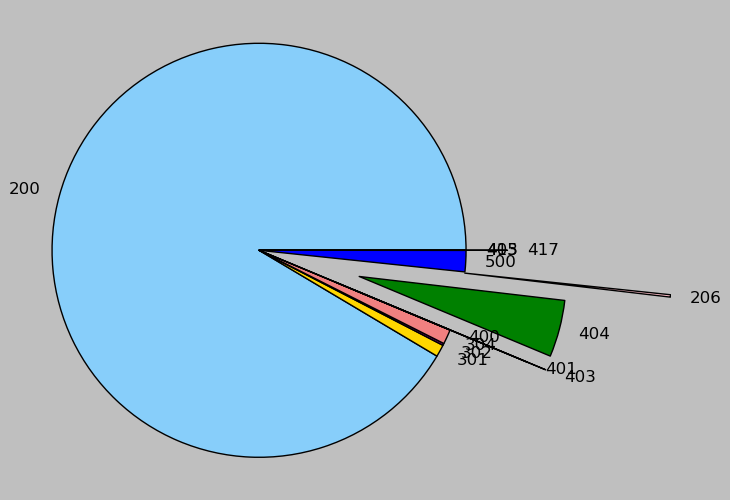

In [103]:
import matplotlib.pyplot as plt
colors = ['red', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black','orange', 'green', 'pink', 'blue',
         'aqua', 'darkgreen']
print labels
def fixPercent(percent):
    return "%.2f"

explode = [.2, 0, 0, 0, 0, 0, .4, .5, .5, 1,0, 0, 0]
print len(explode)
plt.pie(proportions, labels = labels, colors=colors, explode= explode)
plt.axis('equal')

## Further analysis, temporal analysis